# Structure embedding evaluation (41 repositories / test set)

## 1. Loading repository information

In [18]:
!pip install gdown
!gdown 1EE5y_u2_RTWk0k1Z2RwELj1eHoc7WeH_

Downloading...
From: https://drive.google.com/uc?id=1EE5y_u2_RTWk0k1Z2RwELj1eHoc7WeH_
To: /content/repo_info_test.pkl
100% 19.8M/19.8M [00:00<00:00, 151MB/s]


In [19]:
import pickle

with open("repo_info_test.pkl", "rb") as f:
    repo_info = pickle.load(f)
    f.close()

## 2. Download pre-trained model

In [20]:
!pip3 install torch
!pip3 install transformers
!pip3 install sentence-transformers

In [21]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [22]:
sentence_transformer_model_names = [
    "sentence-transformers/bert-base-nli-mean-tokens",
]

In [23]:
from sentence_transformers import SentenceTransformer

sentence_transformer_models = {}

# Initialise sentence transformer model
for s_name in sentence_transformer_model_names:
    sentence_transformer_models[s_name] = SentenceTransformer(model_name_or_path=s_name, device=device)

## 3. Generating structure embeddings

In [24]:
# Getting other embbeddings
def get_other_embeddings(data_list):
    embeddings = {}

    # Sentence transformer model
    for s_name, s_model in tqdm(sentence_transformer_models.items()):
        print(f" - Using {s_name} model - ")
        embeddings_list = s_model.encode(data_list, convert_to_tensor=True)
        embeddings[s_name] = embeddings_list

    return embeddings


# Getting embeddings
def get_embeddings(input_data=None, input_mode=None):
    if input_data is None or not input_data:
        return torch.zeros((768,), device=device)

    with torch.no_grad():
        if input_mode == "structure":
            return get_other_embeddings(input_data)


In [25]:
from tqdm import tqdm

for repo_name, repo_dict in tqdm(repo_info.items()):
    print(f" - Generating structure embeddings for {repo_name} - ")
    repo_dict["structure_embeddings"] = get_embeddings(input_data=repo_dict["structure"], input_mode="structure")

  0%|          | 0/41 [00:00<?, ?it/s]

 - Generating structure embeddings for ellisonleao/pyshorteners - 



  2%|▏         | 1/41 [00:00<00:05,  7.22it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for sloria/doitlive - 



100%|██████████| 1/1 [00:00<00:00, 56.65it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for sebastien/cuisine - 



100%|██████████| 1/1 [00:00<00:00, 53.83it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for lepture/authlib - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 48.09it/s]


 - Generating structure embeddings for inducer/pudb - 



 12%|█▏        | 5/41 [00:00<00:01, 22.46it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for uber/pyflame - 



100%|██████████| 1/1 [00:00<00:00, 58.05it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for aws/aws-cli - 



100%|██████████| 1/1 [00:00<00:00, 61.07it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for DamnWidget/anaconda - 



100%|██████████| 1/1 [00:00<00:00, 67.25it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for pykong/copier - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 46.69it/s]


 - Generating structure embeddings for FactoryBoy/factory_boy - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 24%|██▍       | 10/41 [00:00<00:01, 30.45it/s]

 - Generating structure embeddings for pynamodb/PynamoDB - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 53.14it/s]


 - Generating structure embeddings for jschneier/django-storages - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 54.51it/s]


 - Generating structure embeddings for robotframework/robotframework - 



100%|██████████| 1/1 [00:00<00:00, 56.85it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for mininet/mininet - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 57.04it/s]


 - Generating structure embeddings for ztane/python-Levenshtein - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 37%|███▋      | 15/41 [00:00<00:00, 34.64it/s]

 - Generating structure embeddings for audreyr/cookiecutter - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 58.62it/s]


 - Generating structure embeddings for google/python-fire - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 59.77it/s]


 - Generating structure embeddings for pycco-docs/pycco - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 54.63it/s]


 - Generating structure embeddings for rossgoodwin/hmap - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 54.12it/s]


 - Generating structure embeddings for idan/oauthlib - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 49%|████▉     | 20/41 [00:00<00:00, 37.24it/s]

 - Generating structure embeddings for paramiko/paramiko - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 57.23it/s]


 - Generating structure embeddings for kevin1024/vcrpy - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 51.98it/s]


 - Generating structure embeddings for platformio/platformio-core - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 52.23it/s]


 - Generating structure embeddings for graphql-python/graphene - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 57.20it/s]


 - Generating structure embeddings for klen/mixer - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 61%|██████    | 25/41 [00:00<00:00, 38.61it/s]

 - Generating structure embeddings for seatgeek/sixpack - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 57.34it/s]


 - Generating structure embeddings for bpython/bpython - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 54.42it/s]


 - Generating structure embeddings for dfunckt/django-rules - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 57.56it/s]


 - Generating structure embeddings for coleifer/peewee - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 48.82it/s]


 - Generating structure embeddings for pythonnet/pythonnet - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 73%|███████▎  | 30/41 [00:00<00:00, 39.70it/s]

 - Generating structure embeddings for python/typeshed - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 60.97it/s]


 - Generating structure embeddings for KoffeinFlummi/Chronyk - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 55.23it/s]


 - Generating structure embeddings for isnowfy/snownlp - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 62.12it/s]


 - Generating structure embeddings for alecthomas/voluptuous - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 52.85it/s]


 - Generating structure embeddings for spulec/freezegun - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 85%|████████▌ | 35/41 [00:00<00:00, 39.37it/s]

 - Generating structure embeddings for maxmind/geoip-api-python - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 58.28it/s]


 - Generating structure embeddings for pallets/werkzeug - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 53.83it/s]


 - Generating structure embeddings for nvbn/thefuck - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 45.22it/s]


 - Generating structure embeddings for benfred/implicit - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 95%|█████████▌| 39/41 [00:01<00:00, 38.85it/s]

 - Generating structure embeddings for erikrose/more-itertools - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 54.25it/s]


 - Generating structure embeddings for PyMySQL/mysqlclient-python - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 41/41 [00:01<00:00, 35.85it/s]


## 4. Saving structure embeddings

In [26]:
# Change the tensor format to CPU
save_device = "cpu"

for repo_name, repo_dict in repo_info.items():
    if type(repo_dict["structure_embeddings"]) is torch.Tensor:
        repo_info[repo_name]["structure_embeddings"] = repo_info[repo_name]["structure_embeddings"].to(save_device)
    else:
        for model_name, model_tensor in repo_dict["structure_embeddings"].items():
            repo_info[repo_name]["structure_embeddings"][model_name] = model_tensor.to(save_device)

In [27]:
# Check the tensor format
for repo_name, repo_dict in repo_info.items():
    if type(repo_dict["structure_embeddings"]) is torch.Tensor:
        print(repo_dict["structure_embeddings"].get_device())
    else:
        for model_name, model_tensor in repo_dict["structure_embeddings"].items():
             print(repo_info[repo_name]["structure_embeddings"][model_name].get_device())

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


In [28]:
with open("repo_info_test_structure_embeddings.pkl", "wb") as f:
    pickle.dump(repo_info, f)
    f.close()

## 5. Calculating similarity

In [29]:
from torch.nn import CosineSimilarity
from itertools import combinations
import pandas as pd

cossim = CosineSimilarity(dim=0, eps=1e-8)
res = []
num_of_repos = len(repo_info)
num_of_rows = num_of_repos * (num_of_repos - 1) // 2

models = sentence_transformer_model_names

for repo1, repo2 in tqdm(combinations(repo_info.keys(), 2), total=num_of_rows):
    row = [repo1, repo2, repo_info[repo1]["topic"], repo_info[repo2]["topic"]]
    for model_name in models:

        if type(repo_info[repo1]["structure_embeddings"]) is torch.Tensor:
            embedding1 = repo_info[repo1]["structure_embeddings"]
        else:
            embedding1 = torch.mean(repo_info[repo1]["structure_embeddings"][model_name], dim=0)

        if type(repo_info[repo2]["structure_embeddings"]) is torch.Tensor:
            embedding2 = repo_info[repo2]["structure_embeddings"]
        else:
            embedding2 = torch.mean(repo_info[repo2]["structure_embeddings"][model_name], dim=0)

        similarity = cossim(embedding1, embedding2).cpu().detach().numpy().item()
        row.append(similarity)

    res.append(row)

df = pd.DataFrame(res, columns=["repo1", "repo2", "topic1", "topic2"] + models)
df

100%|██████████| 820/820 [00:00<00:00, 15894.78it/s]


,repo1,repo2,topic1,topic2,sentence-transformers/bert-base-nli-mean-tokens
0,ellisonleao/pyshorteners,sloria/doitlive,URL Manipulation,Productivity CLI Tools,0.666088
1,ellisonleao/pyshorteners,sebastien/cuisine,URL Manipulation,SSH-style Deployment,0.628838
2,ellisonleao/pyshorteners,lepture/authlib,URL Manipulation,OAuth,0.666088
3,ellisonleao/pyshorteners,inducer/pudb,URL Manipulation,pdb-like Debugger,0.666088
4,ellisonleao/pyshorteners,uber/pyflame,URL Manipulation,Profiler,0.628838
...,...,...,...,...,...
815,nvbn/thefuck,erikrose/more-itertools,Productivity CLI Tools,Functional Programming,0.793715
816,nvbn/thefuck,PyMySQL/mysqlclient-python,Productivity CLI Tools,MySQL,0.789199
817,benfred/implicit,erikrose/more-itertools,Recommender Systems,Functional Programming,0.704664
818,benfred/implicit,PyMySQL/mysqlclient-python,Recommender Systems,MySQL,0.721410


In [30]:
df.dropna(inplace=True, subset=models)
df.reset_index(drop=True, inplace=True)
df

,repo1,repo2,topic1,topic2,sentence-transformers/bert-base-nli-mean-tokens
0,ellisonleao/pyshorteners,sloria/doitlive,URL Manipulation,Productivity CLI Tools,0.666088
1,ellisonleao/pyshorteners,sebastien/cuisine,URL Manipulation,SSH-style Deployment,0.628838
2,ellisonleao/pyshorteners,lepture/authlib,URL Manipulation,OAuth,0.666088
3,ellisonleao/pyshorteners,inducer/pudb,URL Manipulation,pdb-like Debugger,0.666088
4,ellisonleao/pyshorteners,uber/pyflame,URL Manipulation,Profiler,0.628838
...,...,...,...,...,...
815,nvbn/thefuck,erikrose/more-itertools,Productivity CLI Tools,Functional Programming,0.793715
816,nvbn/thefuck,PyMySQL/mysqlclient-python,Productivity CLI Tools,MySQL,0.789199
817,benfred/implicit,erikrose/more-itertools,Recommender Systems,Functional Programming,0.704664
818,benfred/implicit,PyMySQL/mysqlclient-python,Recommender Systems,MySQL,0.721410


In [31]:
df.to_csv("structure_embedding_evaluation_test_41.csv")

## 6. Evaluating different models

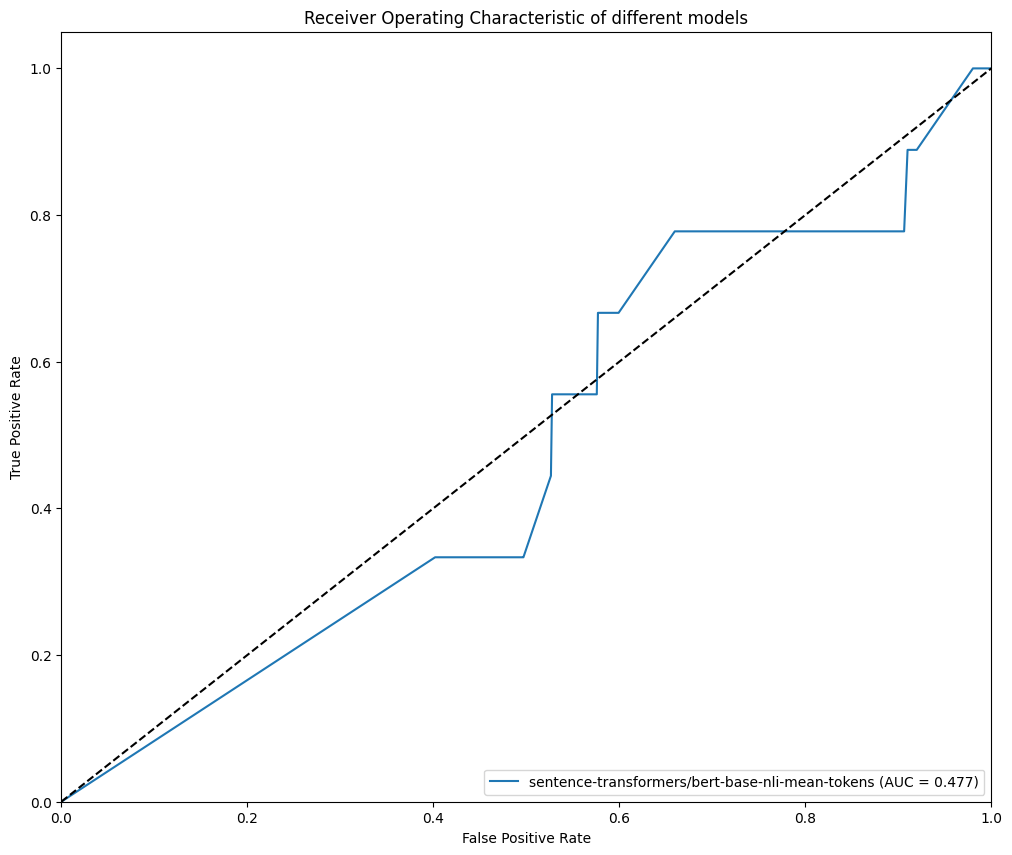

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_auc = {}
y_true = df['topic1'] == df['topic2']
fig = plt.figure(figsize=(12, 10))


def roc(model_name):
    y_score = df[model_name]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    model_auc[model_name] = roc_auc

    plt.plot(fpr, tpr, label=model_name)


for model in models:
    roc(model)

# Order labels by each model's auc score
handles, labels = plt.gca().get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: -model_auc[labels[k]])
ordered_handles = [handles[idx] for idx in order]
ordered_labels = [f'{labels[idx]} (AUC = {model_auc[labels[idx]]:.3f})' for idx in order]
plt.legend(ordered_handles, ordered_labels, loc="lower right")

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic of different models')
plt.savefig('roc_structure_evaluation_test_41.png')
plt.show()

In [33]:
model_auc

{'sentence-transformers/bert-base-nli-mean-tokens': 0.4771201534456775}